### Bangladesh Population in Unions (ADM4 Level)
- GeoCode is obtained from [BBS Geo Location Registry](http://app.dghs.gov.bd/bbscode/)
- Bangladesh population is **144,043,697** (BBS) and **149,273,778** (WorldBank) in 2011, and **159,670,593** (WorldBank) in 2017.
- 'bgd_admbnda_adm4_bbs_20180410.shp' has 5,160 unions
- Municipal Corporations, also known as **Paurasava**, are the local governing bodies of the cities and towns in Bangladesh. There are 327 such municipal corporations in eight divisions of Bangladesh. The Paurasava consists of multiple Wards and is spatially represented as a single feature with PCODE likes "XXXXXX99". However, the city coporation has its own Wards that are spatially represented in the shapefile.
- Mymensingh (45) division consists of 4 districts: Sherpur (4589), Jamalpur (4539), Mymensingh (4561), Netrakona (4572). It was created in 2015 from districts previously comprising the northern part of Dhaka Division in 2015. In the 2011 Census data, these districts are included into Dhaka division (30). So we need to modify it in order to link with 2018 Shapefile.

In [118]:
import numpy as np
import pandas as pd
import xlsxwriter
import geopandas as gpd
from tabula import read_pdf
import fhv

In [119]:
shape_raw = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm4_bbs_20180410.shp')
shape = shape_raw[shape_raw.columns[[12,11,10,9,8,7,3,2]]].sort_values('ADM4_PCODE').reset_index(drop=True)
ucode_shape = shape[['ADM4_PCODE','ADM4_EN']]
ucode_shape.columns = ['Ucode','Name']

### Load BBS Geocode Union PDFs
We need to import this files in order to identify/classify city corporations and paurasava.

In [120]:
if False:
    # Barisal (10)
    df = read_pdf('./data/union/Geocode Union_Barisal2015.pdf',pages='all',multiple_tables=False,
                  pandas_options={'header':0,'skiprows':3})
    df10 = df.drop(df.columns[-1], axis=1).dropna(axis=0, how='all').reset_index(drop=True)
    df10.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    # Chittagong (20)
    df = pd.read_excel('./data/union/Geocode Union_Chittagong2015.xlsx',header=0, skiprows=1)
    df = df.dropna(axis=0, how='all').reset_index(drop=True)
    df.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    df = df.loc[df['Division'] != 'Division']
    df20 = df.loc[df['Division'] != -1]
    # Dhaka (30)
    df = read_pdf('./data/union/Geocode Union_Dhaka2015.pdf',pages='all',multiple_tables=False,
                  pandas_options={'header':0,'skiprows':2})
    df30 = df.dropna(axis=0, how='all').reset_index(drop=True)
    df30.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    # Khulna (40)
    df = read_pdf('./data/union/Geocode Union_Khulna2015.pdf',pages='all',multiple_tables=False,
                  pandas_options={'header':0,'skiprows':2})
    df40 = df.dropna(axis=0, how='all').reset_index(drop=True)
    df40.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    # Rajshahi (50)
    df = read_pdf('./data/union/Geocode Union_Rajshahi2015.pdf',pages='all',multiple_tables=False,
                  pandas_options={'header':0,'skiprows':2})
    df50 = df.dropna(axis=0, how='all').reset_index(drop=True)
    df50.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    # Rangpur (55)
    df = read_pdf('./data/union/Geocode Union_Rangpur2015.pdf',pages='all',multiple_tables=False,
                  pandas_options={'header':0,'skiprows':2})
    df55 = df.dropna(axis=0, how='all').reset_index(drop=True)
    df55.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    # Sylhet (60)
    df = read_pdf('./data/union/Geocode Union_Sylhet2015.pdf',pages='all',multiple_tables=False,
                  pandas_options={'header':0,'skiprows':2})
    df60 = df.dropna(axis=0, how='all').reset_index(drop=True)
    df60.columns = ['Division','Zila','Upazila','Paurasava','Union','Name']
    # Merge
    df = pd.concat([df10, df20, df30, df40, df50, df55, df60])
    # Remove unnecessary rows
    remove = (df['Name'].isna()) | (df['Name'] == 'Name') | (df['Name'] == '(6)')
    df = df[~remove]
    # Split merged codes in Paurasava column
    targ = df['Paurasava'].str.len() == 5
    new = df.loc[targ, 'Paurasava'].str.split(' ',n=1,expand = True)
    df.loc[targ, 'Paurasava'] = new[0]
    df.loc[targ, 'Union'] = new[1]
    gcode = df.reset_index(drop=True)
    # Change dtype to float
    gcode[gcode.columns[:-1]] = gcode[gcode.columns[:-1]].astype(np.float)
    gcode.to_excel('./data/union/Geocode Union.xlsx')
else:
    gcode = pd.read_excel('./data/union/Geocode Union_modified.xlsx',index_col=0)   # Modified

### Load Union Statistics (BBS, 2011)
Reads BBS 2011 Census - Union Statistics (union_stats_extracted.xlsx)

In [121]:
# Load extracted (converted from PDF manually by Donghoon)
df = pd.read_excel('./data/union/union_stats_extracted.xlsx',
                   skiprows=0,header=0,skipfooter=0)

### MANUALLY REMOVE ROWS ###
# Remove row of 'Brahmanpara  Paurashava' (This is unnessary row)
df = df.drop(df.index[df['Name'] == 'Brahmanpara  Paurashava'].values, axis=0).reset_index(drop=True)
df = df[df['Name'].str.contains("chittagang cnt.",case=False) == False]
# Change name ('KADAMRASUL PAURASHA')
df.loc[df['Name'].str.contains('KADAMRASUL PAURASHA',case=False),'Name'] = 'KADAMRASUL PAURASHAVA'
# Change name ('KADAMRASUL PAURASHA')
df.loc[df['Name'].str.contains('KALIGANJ PAURSHAVA',case=False),'Name'] = 'KALIGANJ PAURASHAVA'

# Add a column of Paurasava
df.insert(3, "Paurasava",np.full(df.shape[0], np.nan))
# Creat a subset of data
stat = df[df.columns[:6]].copy()
stat[stat.columns[:5]] = stat[stat.columns[:5]].astype('float')

# Assign Paurasava values from Geocode
union_gcode = gcode['Division']*10**6+gcode['Zila']*10**4+gcode['Upazila']*10**2+gcode['Union']
union_stat = stat['Division']*10**6+stat['Zila']*10**4+stat['Upazila']*10**2+stat['Union']
same = np.intersect1d(union_stat,union_gcode, return_indices=True, assume_unique=False)
stat.iloc[same[1],3] = gcode.iloc[same[2],3].values
# ID for unselected unions
stat.loc[stat['Name'].str.contains(' union',na=False,case=False),'Paurasava'] = 99
# ID for Paurashava rows
stat = stat.reset_index(drop=True)
ip = stat.index[stat['Name'].str.contains('paurasha',na=False,case=False)].values                                   
stat.iloc[ip,3] = stat.iloc[ip+1,3].values

# Insert 8 digits UCODE
stat['Ucode'] = stat['Division']*10**6+stat['Zila']*10**4+stat['Upazila']*10**2+stat['Union']
stat = stat[stat.columns[[0,1,2,3,4,6,5]]]

### MANUAL CHANGES (ADD/REMOVE) ###
# - Restore missing names in the official documents
stat.loc[stat['Ucode'] == 50882727, 'Name'] = 'KHAS KAULIA'

# Change names (removing total and union in the strings)
targ = stat['Union'].notna()
name = stat.loc[targ,'Name'].reset_index(drop=True)
name = name.str.replace(' Total','')
name = name.str.replace(' union','')
name = name.str.replace(' Union','')
name = name.str.replace(' Unio','')
name = name.str.replace(' Dakshin','')

stat.loc[targ,'Name'] = name.values
stat['Name'] = stat['Name'].str.upper()

### ADD MISSED ROWS ###
def InsertRows(dfstat, head, rows):
    '''This function isert rows right below the head row and return df.
    '''
    dfstat = dfstat.copy()
    rows = pd.DataFrame(rows, columns=dfstat.columns)
    tdx = np.argwhere([dfstat['Name'] == head])[0][1]
    dfstat = pd.concat([dfstat.iloc[:tdx+1], rows, dfstat.iloc[tdx+1:]]).reset_index(drop=True)
    return dfstat

# Under "CHAPITALA"
rows = [(20,19,81,99,27,20198127,'DARORA'),
        (20,19,81,99,31,20198131,'CHHALIAKANDI'),
        (20,19,81,99,36,20198136,'DHAMGHAR')]
stat = InsertRows(stat, 'CHAPITALA', rows)
# Under "BARA BAKIA"
rows = [(20,22,56,99,55,20225655,'UJANTIA')]
stat = InsertRows(stat, 'BARA BAKIA', rows)
# Under "GHARJAN"
rows = [(50,88,27,99,27,50882727,'KHAS KAULIA')]
stat = InsertRows(stat, 'GHARJAN', rows)

# Retouch Code
stat['Ucode'] = stat['Division']*10**6+stat['Zila']*10**4+stat['Upazila']*10**2+stat['Union']
# - Insert ADM3_PCODE TO stat
stat.insert(3, 'ADM3_PCODE', stat['Division']*10**4+stat['Zila']*10**2+stat['Upazila'])

# Subset of Union codes and names
targ = stat['Union'].notna()
ucode_stat = stat[['Ucode','Name']][targ].reset_index(drop=True)

# Save (temporarily)
# stat.to_excel('./data/union/stat_temp.xlsx')

### Load Union Population in Age 5 years group
Reads BBS 2011 Census - Union Age5 population data (e.g., age5_Rangpur.xls)
- Some unions don't have rows (no population) for some age 5 years groups...

In [122]:
# Load each files
df10 = fhv.LoadUnionAge5('./data/union/age5_Barisal.xls')
df20 = fhv.LoadUnionAge5('./data/union/age5_Chittagong_modified.xls')
df30 = fhv.LoadUnionAge5('./data/union/age5_Dhaka_modified.xls')
df40 = fhv.LoadUnionAge5('./data/union/age5_Khulna.xls')
df50 = fhv.LoadUnionAge5('./data/union/age5_Rajshahi_modified.xls')
df55 = fhv.LoadUnionAge5('./data/union/age5_Rangpur.xls')
df60 = fhv.LoadUnionAge5('./data/union/age5_Sylhet_modified.xls')
df = pd.concat([df10, df20, df30, df40, df50, df55, df60])

# Restore names when Union ID were assigned
targ = df['Union'].astype(str).str.isdigit()
name = df.loc[targ, 'Union']
name_num = np.unique(name)
name_str = ucode_stat.iloc[np.intersect1d(name_num, ucode_stat['Ucode'],return_indices=True)[2],1].values
for i, val in enumerate(name_num):
    name.loc[name == val] = name_str[i]
df.loc[targ, 'Union'] = name

### MANUAL CHANGES (REMOVE/ADD ROWS) ###
df = df[(df['Union'].str.lower() == "chittagang cnt.") == False].reset_index(drop=True)

# Capitalize characters
ucode_age5 = df[df['Age5'] == 'Total']['Union'].reset_index(drop=True)

# "ucode_stat" and "ucode_age5" are cross-validated (by Donghoon)
if False:
    # Retouch (Remove "Union", "Dakshin")
    ucode_age5 = ucode_age5.str.upper()
    ucode_age5 = ucode_age5.str.replace(' UNION','')
    ucode_age5 = ucode_age5.str.replace(' DAKSHIN','')
    ucode_age5 = ucode_age5.str.replace('LAKSHMIPUR MODEL','SAKHUA')
    # Save Ucodes to comparison
    writer = pd.ExcelWriter('./data/union/ucode_comp.xlsx', engine='xlsxwriter')
    ucode_shape.to_excel(writer, sheet_name='Sheet2')
    ucode_stat.to_excel(writer, sheet_name='Sheet1', startcol=0)
    ucode_age5.to_excel(writer, sheet_name='Sheet1', startcol=3)
    writer.save()
    
# Copy and Modify a dataframe
age5 = df.copy()
diff = age5[age5['Age5'] == 'Total'].index.values + 1
leng = np.append(diff[0],diff[1:] - diff[:-1])
swap = ucode_stat['Ucode'].repeat(leng)
age5['Union'] = swap.values
total = age5.pivot(index='Union',columns='Age5',values='Total')
total.index = total.index.astype(int)

### Link Shapfile IDs to Union Statistics
We will change division codes of unions in Mymensingh (45) to Dhaka (30), then link to the data and rechange them later.

In [123]:
# Control Mymensingh (45) division (total 378 unions)
# - Mymensingh (45): Sherpur (4589), Jamalpur (4539), Mymensingh (4561), Netrakona (4572)
f45t30 = '30' + shape.loc[shape['ADM1_PCODE'] == '45', 'ADM4_PCODE'].str[2:]
shape.loc[shape['ADM1_PCODE'] == '45', 'ADM4_PCODE'] = f45t30.values

# Create an empty dataframe to be filled with data
group = total.columns
data = pd.DataFrame(index=shape['ADM4_PCODE'],columns=group).reset_index()
data.insert(1, 'Name1', shape['ADM4_EN'])
data.insert(2, 'Name2', np.NaN)
data.columns.name = ''
igroup = data.columns.get_indexer(group)

# Copy matched unions with UCODE
match = np.intersect1d(shape['ADM4_PCODE'].astype(int), total.index, return_indices=True)
data.iloc[match[1],igroup] = total.iloc[match[2],:].values
data.iloc[match[1],2] = ucode_stat.iloc[match[2],1].values

print("Missing unions: %d" % data['Name2'].isna().sum())
print('Total Population: %d' % data['Total'].sum())

Missing unions: 334
Total Population: 127982634


In [124]:
# Quick matching using name of Paurashava
# - Paurashava list
plist = data.loc[data['Name2'].isna(), ['ADM4_PCODE','Name1']]
plist.insert(0, 'ADM3_PCODE', plist['ADM4_PCODE'].str[:6].astype(int))

for idx, row in plist.iterrows():

    code3 = row['ADM3_PCODE']
    code4 = row['ADM4_PCODE']
    name = row['Name1']
    cond1 = name.lower().find(' paurashava') != -1
    if cond1:
        sname = name.lower().replace(' ','')

        # Find corresponding table in STAT with name and ADM3 code
        stat[stat['ADM3_PCODE'] == code3]
        # Paurasava codes ("99" means nomal union)
        targ = (stat['ADM3_PCODE'] == code3) & (stat['Paurasava'].notna()) & (stat['Paurasava'] != 99) 
        pcode = np.unique(stat.loc[targ,'Paurasava'])
        table = stat.loc[targ,['Paurasava','Union','Ucode','Name']]   # Corresponding table

        cond2 = np.sum(table['Name'].str.replace(' ','') == sname.upper()) == 1
        if cond2:
            table['Name'].str.replace(' ','')
            go = table['Name'].str.replace(' ','') == sname.upper()

            # Select the rows of Wards to be merged to Paurashava
            go_name = table.loc[go, 'Name'].values[0]
            go_ucode = table.loc[~go,'Ucode'].values
            # Insert Name and Merged data to Paurashava
            data.iloc[idx, 3:] = total[total.index.isin(go_ucode)].sum(skipna=True).values
            data.iloc[idx, 2] = go_name
            
print("Missing unions: %d" % data['Name2'].isna().sum())
print('Total Population: %d' % data['Total'].sum())

Missing unions: 83
Total Population: 143157641


In [125]:
### CONTROL PAURASHAVA
# - Paurashava list
plist = data.loc[data['Name2'].isna(), ['ADM4_PCODE','Name1']]
plist.insert(0, 'ADM3_PCODE', plist['ADM4_PCODE'].str[:6].astype(int))
# - ADM3_PCODE List
adm3List = np.unique(plist['ADM3_PCODE'])

# Apply an Algorithm per ADM3 unit
for adm3 in adm3List:

    # Potential Paurasava(s) in the current ADM3_PCODE
    adm4List = plist[plist['ADM3_PCODE'] == adm3]

    # Paurasava codes ("99" means nomal union)
    targ = (stat['ADM3_PCODE'] == adm3) & (stat['Paurasava'].notna()) & (stat['Paurasava'] != 99) 
    pcode = np.unique(stat.loc[targ,'Paurasava'])
    table = stat.loc[targ,['Paurasava','Union','Ucode','Name']]   # Corresponding table

    # Find the row of Paurashava
    go = table['Ucode'].isna()
    if (adm4List.shape[0] == 1) & (go.sum() == 1):
        # (1) Single unmatched union & Single Paurashava in ADM3

        # Select the rows of Wards to be merged to Paurashava
        go_name = table.loc[go, 'Name'].values[0]
        go_ucode = table.loc[~go,'Ucode'].values
        # Insert Name and Merged data to Paurashava
        data.iloc[adm4List.index, 3:] = total[total.index.isin(go_ucode)].sum(skipna=True).values
        data.iloc[adm4List.index, 2] = go_name

    elif (adm4List.shape[0] > 1) & (go.sum() == 1):
        # (2) Multiple unmatched unions & Single Paurashava in ADM3
        if adm4List['Name1'].str.contains('paurashava', case=False).sum() == 1:
            # Only one Paurashava (Ignore others)
            adm4True = adm4List[adm4List['Name1'].str.contains('paurashava', case=False)]

            # Select the rows of Wards to be merged to Paurashava
            go_name = table.loc[go, 'Name'].values[0]
            go_ucode = table.loc[~go,'Ucode'].values
            # Insert Name and Merged data to Paurashava
            data.iloc[adm4True.index, 3:] = total[total.index.isin(go_ucode)].sum(skipna=True).values
            data.iloc[adm4True.index, 2] = go_name

    elif (adm4List.shape[0] == 1) & (go.sum() > 1):        
        # (3) Single unmatched union & Multiple Paurashavas in ADM3

        # Select the rows of Wards to be merged to Paurashava
        go_name = table.loc[go, 'Name'].values[0]
        go_ucode = table.loc[~go,'Ucode'].values
        # Insert Name and Merged data to Paurashava
        data.iloc[adm4List.index, 3:] = total[total.index.isin(go_ucode)].sum(skipna=True).values
        data.iloc[adm4List.index, 2] = go_name

print("Missing unions: %d" % data['Name2'].isna().sum())
print('Total Population: %d' % data['Total'].sum())

Missing unions: 15
Total Population: 146462896


### Post processing
- We have two Ranges: Sharankhola Rnage (40017797), Kkulna Range (40471797)
- And we assume other three Ranges have no population: Chandpai Range (40015897), Nalian Range (40475397), Satkhira Range (40878697)

In [126]:
# Ranges
target = [40015897,40475397,40878697]
tdx = data['ADM4_PCODE'].astype(int).isin(target)
data.loc[tdx,'Name2'] = data.loc[tdx,'Name1'].values
data.loc[tdx,data.columns[3:]] = 0

# Merging Manually
targ = 50108599; ref = [50108513, 50108514, 50108521]
tdx = data['ADM4_PCODE'].astype(int).isin([targ])
data.loc[tdx,'Name2'] = 'SHAJAHANPUR Paurashava'
data.loc[tdx,data.columns[3:]] = total[total.index.isin(ref)].sum(skipna=True).values

targ = 50108590; ref = [50108598]
tdx = data['ADM4_PCODE'].astype(int).isin([targ])
data.loc[tdx,'Name2'] = stat.loc[stat['Ucode'].isin(ref),'Name'].values
data.loc[tdx,data.columns[3:]] = total[total.index.isin(ref)].sum(skipna=True).values

# NEED TO CHANGE
targ = 50812208; ref = [50818508]
tdx = data['ADM4_PCODE'].astype(int).isin([targ])
data.loc[tdx,'Name2'] = stat.loc[stat['Ucode'].isin(ref),'Name'].values
data.loc[tdx,data.columns[3:]] = total[total.index.isin(ref)].sum(skipna=True).values

# Partition (Need to share ares with reference)
def AreaRatio(data, targ, ref):
    # Change name
    tdx = data['ADM4_PCODE'].astype(int).isin([targ])
    data.loc[tdx,'Name2'] = data.loc[tdx,'Name1'].values
    # Get areas
    tdx = data['ADM4_PCODE'].astype(int).isin([targ, ref])
    assert tdx.sum() == 2
    if targ > 30000000:
        shape_raw_pcode = shape_raw['ADM4_PCODE'].astype(int) - 15000000
    else:
        shape_raw_pcode = shape_raw['ADM4_PCODE'].astype(int)
    it = shape_raw_pcode.isin([targ])
    ir = shape_raw_pcode.isin([ref])
    area_targ = shape_raw.loc[it,'Shape_Area'].values
    area_ref = shape_raw.loc[ir,'Shape_Area'].values
    # Scale population and Divide
    pop_ref = data.loc[data['ADM4_PCODE'].astype(int).isin([ref]), data.columns[3:]].copy()
    data.loc[data['ADM4_PCODE'].astype(int).isin([ref]), data.columns[3:]] = (pop_ref.values * area_ref/(area_ref+area_targ)).astype(int)
    data.loc[data['ADM4_PCODE'].astype(int).isin([targ]), data.columns[3:]] = (pop_ref.values * area_targ/(area_ref+area_targ)).astype(int)    
    return(data)
data = AreaRatio(data.copy(), 20156539,20152039)
data = AreaRatio(data.copy(), 20155715,20154115)
data = AreaRatio(data.copy(), 20155509,20154309)
data = AreaRatio(data.copy(), 20154130,20152830)
data = AreaRatio(data.copy(), 20152812,20155512)
data = AreaRatio(data.copy(), 20152036,20152836)
data = AreaRatio(data.copy(), 30728399,30728394)
data = AreaRatio(data.copy(), 20193329,20193328) # [Belghar Uttar, Belghar]
data = AreaRatio(data.copy(), 20193313,20193312) # [Baghmara Uttar, Baghmara]

# Change NaN to Zero
data[data.isna()] = 0
# Change Dtype
data[data.columns[3:]] = data[data.columns[3:]].astype(int)
# Save
data.to_excel('./data/union/union_merged.xlsx')
print("Missing unions: %d" % data['Name2'].isna().sum())
print('Total Population: %d' % data['Total'].sum())

Missing unions: 0
Total Population: 146536038


### Link data to Shapefile

In [127]:
# Reload a shapefile
shape = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm4_bbs_20180410.shp')
shape = shape.drop(shape.columns[[0,1,4,5,6,13,14,15,16,17]],axis=1)
shape = shape.sort_values('ADM4_PCODE').reset_index(drop=True)
# Restore ADM4_PCODE of Mymensingh (45) division (total 378 unions) (30 -> 45)
f30t45 = '45' + data.loc[shape['ADM1_PCODE'] == '45', 'ADM4_PCODE'].str[2:]
data.loc[shape['ADM1_PCODE'] == '45', 'ADM4_PCODE'] = f30t45.values
assert all(data['ADM4_PCODE'] == shape['ADM4_PCODE'])

In [140]:
# Merge
df = shape.merge(data[['ADM4_PCODE','Total']], on='ADM4_PCODE')
map_union = df.drop(['ADM3_EN','ADM3_PCODE','ADM2_EN','ADM2_PCODE','ADM1_EN','ADM1_PCODE'], axis=1)
# df.to_file('./data/union/union_pop_removable.shp')

### Plotting Union Popultaion

In [169]:
# Initialize mapping parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Proj, transform    # In case of re-projection
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

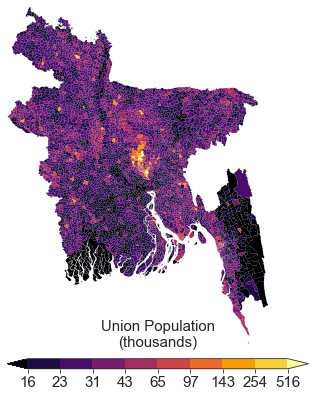

In [176]:
# Mapping
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Colormap
bounds = [15817,23354,31330,43102,65000,97049,142764,253512,515952]
boundaries = [0]+bounds+[655387]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'inferno', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Plotting
figlabel = 'Union Population\n(thousands)'
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
map_union.plot(ax=ax, column='Total', 
        cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0)  
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0, -0.07, 2.5, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%d'% np.round(lb/1000) for lb in np.array(bounds)], 
                        fontname='arial', fontsize=15, rotation=0)
cbar.set_label(figlabel, labelpad=-70, 
               fontname='arial', fontsize=15, 
               horizontalalignment='center')
plt.show()